# Avazu CTR — Exploratory Data Analysis

> This notebook is designed to be safe on the full Avazu `train.csv` (very large) by defaulting to a sample. You can increase the sample size once the workflow is stable.

## Goals
- Validate the dataset schema and basic quality checks
- Understand the target (`click`) rate overall and over time (`hour`)
- Inspect feature distributions, cardinalities, and long tails
- Identify obvious signals and modeling considerations (time-based split, leakage risks)

## Generated report
- Read: `docs/EDA_REPORT.md`
- Regenerate: `python human_src/generate_eda_report.py --sample-parquet data/interim/train_sample.parquet --out-md docs/EDA_REPORT.md`

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns  # type: ignore
    sns.set_theme(style="whitegrid")
except Exception:
    sns = None

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "kaggle_clicks").is_dir() and (p / "data").is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from cwd={start}")

REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from kaggle_clicks.paths import get_paths

# Display / plotting defaults
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

paths = get_paths()
TRAIN_PATH = paths.data_raw / "train.csv"
assert TRAIN_PATH.exists(), f"Missing file: {TRAIN_PATH} (see docs/DATA.md)"

# Keep this modest by default; Avazu train is very large.
SAMPLE_ROWS = 200_000
RANDOM_STATE = 42

def memory_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024**2)

def parse_avazu_hour(hour_series: pd.Series) -> pd.Series:
    # hour format: YYMMDDHH (e.g., 14102100)
    s = hour_series.astype(str).str.zfill(8)
    return pd.to_datetime(s, format="%y%m%d%H", errors="coerce")

def show_df_overview(df: pd.DataFrame) -> pd.DataFrame:
    overview = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_unique": df.nunique(dropna=False),
        "n_missing": df.isna().sum(),
    }).sort_values(["n_unique", "dtype"], ascending=[False, True])
    display(overview)
    return overview

In [2]:
# Load a sample (fast). Increase SAMPLE_ROWS if needed.
# NOTE: `id` can exceed int64; keep it as string.
dtypes = {"id": "string", "click": "int8", "hour": "int32"}

train_df = pd.read_csv(
    TRAIN_PATH,
    nrows=SAMPLE_ROWS,
    dtype=dtypes,
    na_filter=False,
)

train_df["dt"] = parse_avazu_hour(train_df["hour"])
train_df["date"] = train_df["dt"].dt.date
train_df["hour_of_day"] = train_df["dt"].dt.hour
train_df["dow"] = train_df["dt"].dt.day_name()

display(
    pd.DataFrame({
        "rows": [len(train_df)],
        "cols": [train_df.shape[1]],
        "memory_mb": [memory_mb(train_df)],
        "dt_min": [train_df["dt"].min()],
        "dt_max": [train_df["dt"].max()],
        "ctr": [train_df["click"].mean()],
    }),
    train_df.head(3),
)

,rows,cols,memory_mb,dt_min,dt_max,ctr
0,200000,28,167.568789,2014-10-21,2014-10-21 01:00:00,0.174755


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,dt,date,hour_of_day,dow
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79,2014-10-21,2014-10-21,0,Tuesday
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79,2014-10-21,2014-10-21,0,Tuesday
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79,2014-10-21,2014-10-21,0,Tuesday


In [3]:
# Schema / quality checks
overview = show_df_overview(train_df)

# Basic sanity
n_rows = len(train_df)
n_id_unique = train_df["id"].nunique()
n_dt_missing = train_df["dt"].isna().sum()
n_click_pos = int(train_df["click"].sum())

display(pd.DataFrame({
    "rows": [n_rows],
    "id_unique": [n_id_unique],
    "id_dup_rows": [n_rows - n_id_unique],
    "dt_missing": [n_dt_missing],
    "click_positives": [n_click_pos],
    "click_rate": [train_df["click"].mean()],
}))

# Duplicate-row check (excluding id) on a small subset to keep it fast
subset = train_df.sample(min(50_000, n_rows), random_state=RANDOM_STATE).drop(columns=["id"])
dup_rate = subset.duplicated().mean()
display(pd.DataFrame({"dup_rate_excl_id_on_subset": [dup_rate]}))

,dtype,n_unique,n_missing
id,string,200000,0
device_ip,object,76668,0
device_id,object,15040,0
device_model,object,3104,0
site_id,object,1239,0
site_domain,object,1119,0
app_id,object,989,0
C14,int64,480,0
C20,int64,149,0
C17,int64,145,0


,rows,id_unique,id_dup_rows,dt_missing,click_positives,click_rate
0,200000,200000,0,0,34951,0.174755


,dup_rate_excl_id_on_subset
0,0.11752


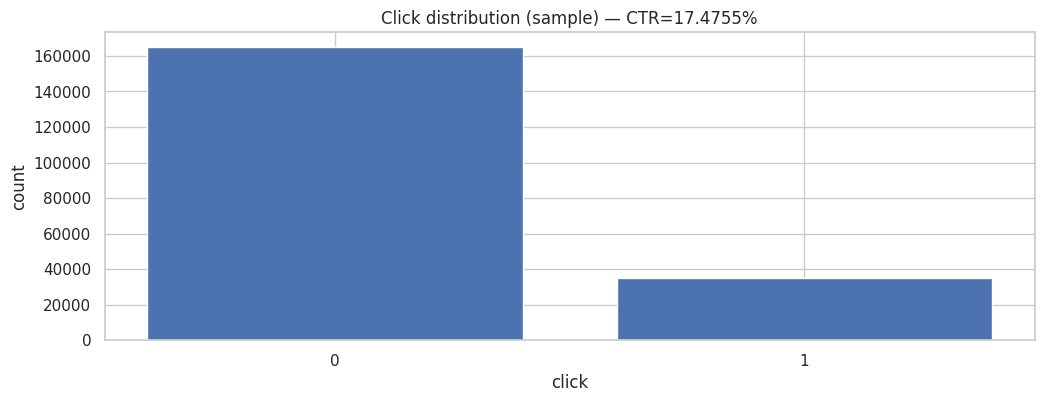

In [4]:
# Target distribution
ctr = train_df["click"].mean()
counts = train_df["click"].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(["0", "1"], [counts.get(0, 0), counts.get(1, 0)])
ax.set_title(f"Click distribution (sample) — CTR={ctr:.4%}")
ax.set_xlabel("click")
ax.set_ylabel("count")
plt.show()

## Time patterns (`hour`)
The Avazu dataset is naturally time-ordered by `hour` (format `YYMMDDHH`). Even on a head-sample you can already sanity-check time parsing and look for strong diurnal/weekly patterns.

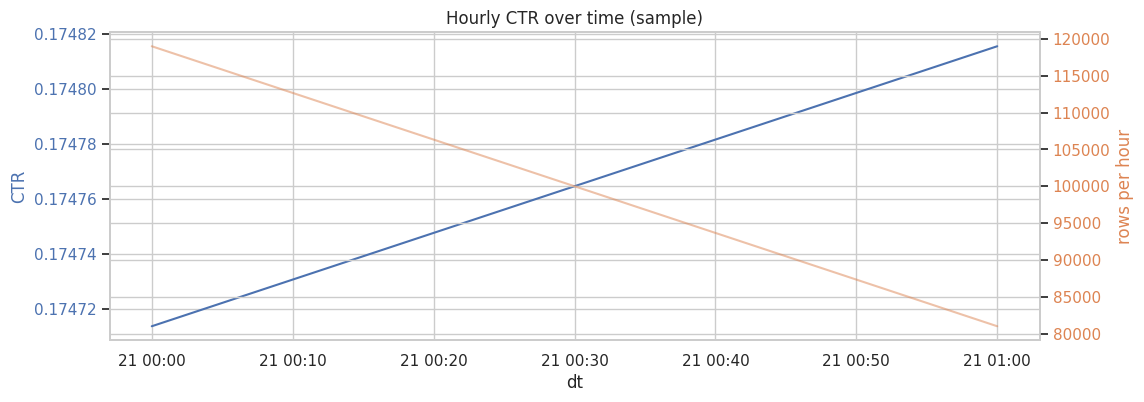

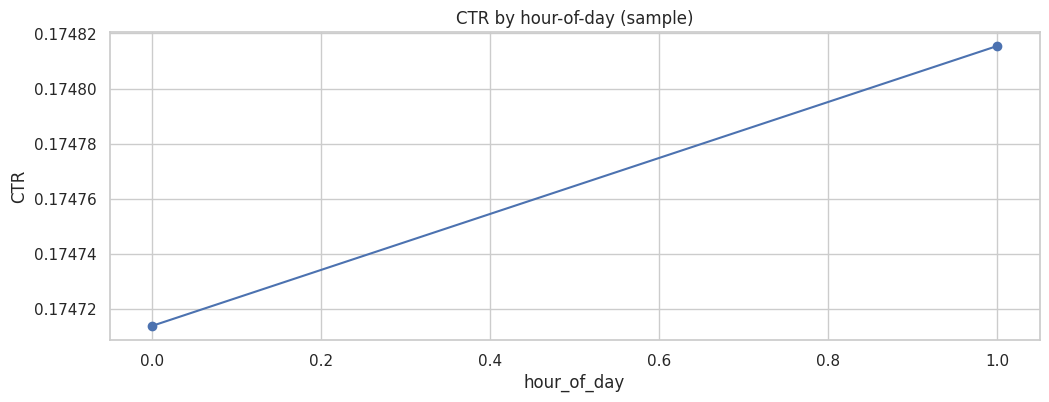

,dow,ctr,n
0,Tuesday,0.174755,200000


In [5]:
# CTR over time (hourly)
hourly = (
    train_df.groupby("dt", sort=True)["click"]
    .agg(ctr="mean", n="size")
    .reset_index()
    .sort_values("dt")
)

fig, ax1 = plt.subplots()
ax1.plot(hourly["dt"], hourly["ctr"], color="C0")
ax1.set_title("Hourly CTR over time (sample)")
ax1.set_xlabel("dt")
ax1.set_ylabel("CTR", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")

ax2 = ax1.twinx()
ax2.plot(hourly["dt"], hourly["n"], color="C1", alpha=0.5)
ax2.set_ylabel("rows per hour", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")
plt.show()

# By hour-of-day
hod = (train_df.groupby("hour_of_day")["click"].agg(ctr="mean", n="size").reset_index())
fig, ax = plt.subplots()
ax.plot(hod["hour_of_day"], hod["ctr"], marker="o")
ax.set_title("CTR by hour-of-day (sample)")
ax.set_xlabel("hour_of_day")
ax.set_ylabel("CTR")
plt.show()

# By day-of-week
dow = (
    train_df.groupby("dow")["click"].agg(ctr="mean", n="size").reset_index()
    .sort_values("n", ascending=False)
)
display(dow)

## Missing values, sentinels, and numeric sanity
Most Avazu columns are hashed categoricals, but there are also known numeric-like fields (e.g., `C14..C21`) where sentinels like `-1` can appear.

In [6]:
# Missingness overview (should be mostly zero; `na_filter=False` above also reduces parsing time)
missing = train_df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].to_frame("n_missing"))

# Numeric-like columns sanity (convert defensively, then inspect)
numeric_like = ["C1", "banner_pos", "device_type", "device_conn_type", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21"]
present_numeric_like = [c for c in numeric_like if c in train_df.columns]

num_view = train_df[present_numeric_like].apply(pd.to_numeric, errors="coerce")
display(num_view.describe(include="all").T)

# Sentinel checks
sentinel = -1
sentinel_counts = (num_view == sentinel).sum().sort_values(ascending=False)
display(sentinel_counts[sentinel_counts > 0].to_frame("n_equal_-1"))

,n_missing


,count,mean,std,min,25%,50%,75%,max
C1,200000.0,1005.020940,1.028794,1001.0,1005.0,1005.0,1005.0,1010.0
banner_pos,200000.0,0.207390,0.409769,0.0,0.0,0.0,0.0,7.0
device_type,200000.0,1.045545,0.548254,0.0,1.0,1.0,1.0,5.0
device_conn_type,200000.0,0.198685,0.635249,0.0,0.0,0.0,0.0,5.0
C14,200000.0,17794.362140,3250.084833,375.0,15705.0,17753.0,20363.0,21705.0
C15,200000.0,318.352400,13.192933,120.0,320.0,320.0,320.0,728.0
C16,200000.0,57.065250,37.470529,20.0,50.0,50.0,50.0,480.0
C17,200000.0,1979.110140,398.900228,112.0,1722.0,1993.0,2316.0,2497.0
C18,200000.0,0.880770,1.252003,0.0,0.0,0.0,2.0,3.0
C19,200000.0,150.211120,256.049867,33.0,35.0,35.0,163.0,1835.0


,n_equal_-1
C20,120873


## Cardinality and long tails
CTR datasets often have extreme long-tail categoricals (e.g., `device_ip`, `device_id`). This section quantifies unique counts and shows the top-frequency categories.

,n_unique
id,200000
device_ip,76668
device_id,15040
device_model,3104
site_id,1239
site_domain,1119
app_id,989
C14,480
C20,149
C17,145


,site_id,count
0,1fbe01fe,65529
1,85f751fd,47415
2,543a539e,11218
3,d9750ee7,8398
4,e151e245,6016
5,5b08c53b,3801
6,030440fe,3008
7,5b4d2eda,2789
8,f282ab5a,2298
9,43d6df75,2267


,site_domain,count
0,f3845767,65529
1,c4e18dd6,50340
2,c7ca3108,11218
3,98572c79,8623
4,7e091613,6322
5,7687a86e,5613
6,08ba7db9,3008
7,16a36ef3,2928
8,27e3c518,2846
9,61eb5bc4,2305


,site_category,count
0,28905ebd,70720
1,50e219e0,54373
2,f028772b,43938
3,3e814130,22337
4,76b2941d,3219
5,335d28a8,2322
6,0569f928,1234
7,f66779e6,686
8,72722551,627
9,75fa27f6,347


,app_id,count
0,ecad2386,152585
1,febd1138,5553
2,e2fcccd2,3989
3,5e3f096f,2728
4,0acbeaa3,2120
5,54c5d545,1763
6,1779deee,1646
7,ffc6ffd0,1421
8,39947756,1306
9,51cedd4e,1278


,app_domain,count
0,7801e8d9,161008
1,2347f47a,17663
2,82e27996,5553
3,5c5a694b,3989
4,d9b5648e,3635
5,45a51db4,2120
6,aefc06bd,1471
7,ae637522,975
8,33da2e74,435
9,0654b444,414


,app_category,count
0,07d7df22,153585
1,0f2161f8,32936
2,f95efa07,5635
3,8ded1f7a,3238
4,cef3e649,3234
5,d1327cf5,405
6,75d80bbe,305
7,4ce2e9fc,194
8,09481d60,103
9,fc6fa53d,100


,device_id,count
0,a99f214a,173222
1,c357dbff,257
2,936e92fb,123
3,31da1bd0,103
4,a167aa83,89
5,e8440dbf,82
6,afcea16a,69
7,3c0208dc,68
8,24c3c3fe,66
9,50c4ddcc,66


,device_ip,count
0,6b9769f2,1579
1,ceffea69,715
2,1cf29716,690
3,9b1fe278,664
4,431b3174,663
5,ddd2926e,660
6,75bb1b58,648
7,57cd4006,648
8,488a9a3e,643
9,c6563308,634


,device_model,count
0,8a4875bd,13951
1,d787e91b,11127
2,1f0bc64f,7451
3,4ea23a13,4512
4,711ee120,3997
5,c6263d8a,3344
6,a0f5f879,3311
7,3bd9e8e7,3050
8,ecb851b2,2965
9,5096d134,2704


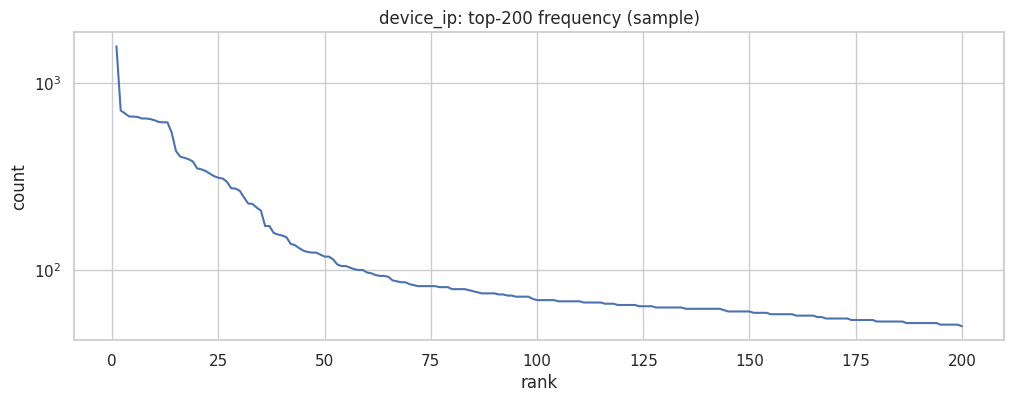

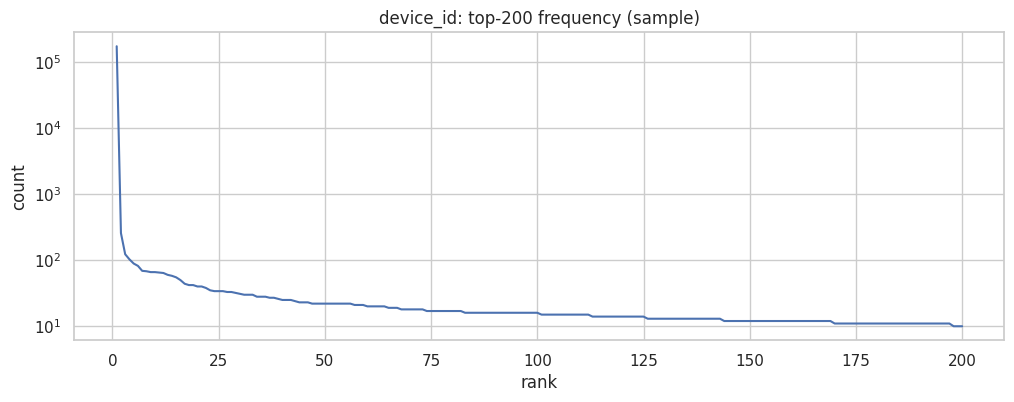

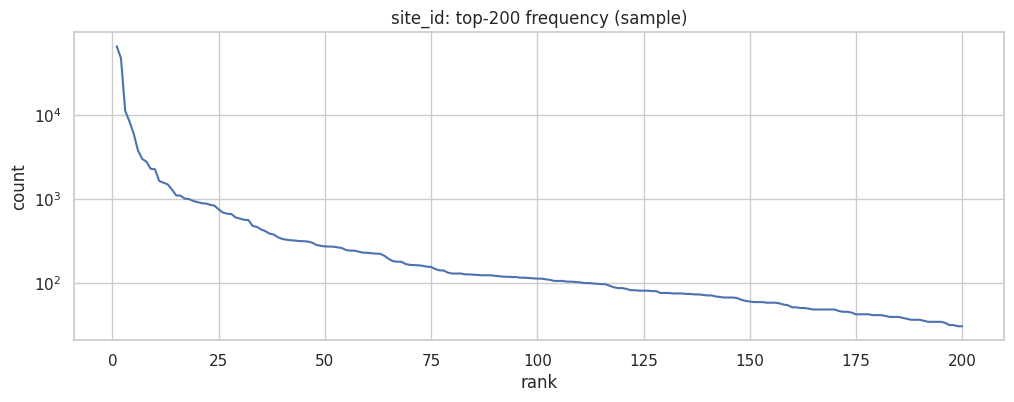

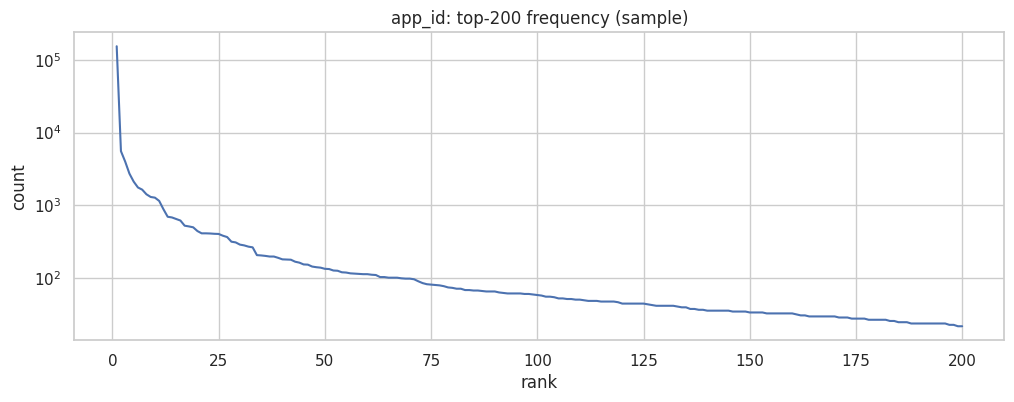

In [7]:
derived_cols = {"dt", "date", "hour_of_day", "dow"}
base_cols = [c for c in train_df.columns if c not in derived_cols]
feature_cols = [c for c in base_cols if c not in {"click"}]

card = (
    train_df[feature_cols]
    .agg(["nunique"])
    .T.rename(columns={"nunique": "n_unique"})
    .sort_values("n_unique", ascending=False)
)
display(card.head(30))

# Show top categories for selected high-cardinality fields
top_fields = [c for c in ["site_id", "site_domain", "site_category", "app_id", "app_domain", "app_category", "device_id", "device_ip", "device_model"] if c in train_df.columns]
for col in top_fields:
    vc = train_df[col].value_counts().head(15)
    display(pd.DataFrame({col: vc.index.astype(str), "count": vc.values}))

# Long-tail visualization for a few key columns (top 200 only)
plot_cols = [c for c in ["device_ip", "device_id", "site_id", "app_id"] if c in train_df.columns]
for col in plot_cols:
    vc = train_df[col].value_counts().head(200)
    fig, ax = plt.subplots()
    ax.plot(np.arange(1, len(vc) + 1), vc.values)
    ax.set_title(f"{col}: top-200 frequency (sample)")
    ax.set_xlabel("rank")
    ax.set_ylabel("count")
    ax.set_yscale("log")
    plt.show()